<a href="https://colab.research.google.com/github/TheOnesThatWereAbroad/Assignment1/blob/main/POS_with_workingF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - POS tagging

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import model_from_json
import keras_tuner as kt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

from data_input import DataInput
from text_vectorizer import TextVectorizer, TargetVectorizer

## 1. Build a dataset

### 1.1 Dataset preparation
For this experiment, the [Dependency Parsed Treebank](https://www.nltk.org/nltk_data/) dataset is used.
Notice that each document is slitted into sentences, so the dimensionality of the data is more than 199 (total number of documents in the dataset)

In [3]:
# download the dataset and split it into train, dev and test sets
dataset = DataInput(
        data_url="https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip",
        train_size=0.50,
        dev_size=0.25,
        dataset_folder=os.path.join(os.getcwd(), "dataset"),
        split_into_sentences=True,
        shuffle=False
    )

Train set size: 1957
Dev set size: 979
Test set size: 978


Pre-processing is always an important step with which start. There are a lot of pre-processing steps that we can consider, but for this experiment the only pre-processing operation performed is:
- **to lower**, in part-of-speech tagging scenario casing of the input tokens is crucial to find the correspondent token in the embedding vocabulary

In [4]:
# do preprocessing for train, validation and test sets
dataset.preprocessing("train", to_lower=True)
dataset.preprocessing("dev", to_lower=True)
dataset.preprocessing("test", to_lower=True)

# separate inputs and targets
X_train, y_train = dataset.train
X_dev, y_dev = dataset.dev
X_test, y_test = dataset.test

In [5]:
dataset.train[0].shape

(1957,)

### 1.2 Dataset analysis
Let's take a look at the dataset, to inspect the distribution of the POS tags

In [6]:
def get_occurences(data, ordered=False, exclude=[]):
    """
    Get the occurences of each token in the data.

    Parameters
    ----------
    data : list of np arrays, representing the data to get the occurences from
    ordered : bool, if True, the occurences will be returned in descending order
    exclude : list of strings, tokens that should not be included in the occurences

    Returns
    -------
    occurences : dict, mapping each token to the number of occurences
    """
    tokens, counts = np.unique(np.concatenate(data), return_counts=True)
    occurences = dict(zip(tokens, counts))

    if len(exclude) > 0:
        for token in exclude:
            if token in occurences:
                del occurences[token]

    if ordered:
        occurences = dict(sorted(occurences.items(), key=lambda x: x[1], reverse=True))
    return occurences

# get the occurences of each POS tag in the three sets 
train_tags_occ = get_occurences(y_train, ordered=True, exclude=[])
dev_tags_occ = get_occurences(y_dev, exclude=[])
test_tags_occ = get_occurences(y_test, exclude=[])

# build a matrix of the occurences of size (n_tags, 3)
tags_occ = np.array([[v, dev_tags_occ[k], test_tags_occ[k]] if k in dev_tags_occ and k in test_tags_occ else [v, dev_tags_occ[k], 0] if k in dev_tags_occ else [v, 0, test_tags_occ[k]] if k in test_tags_occ else [v, 0, 0] for k, v in train_tags_occ.items()])

[]

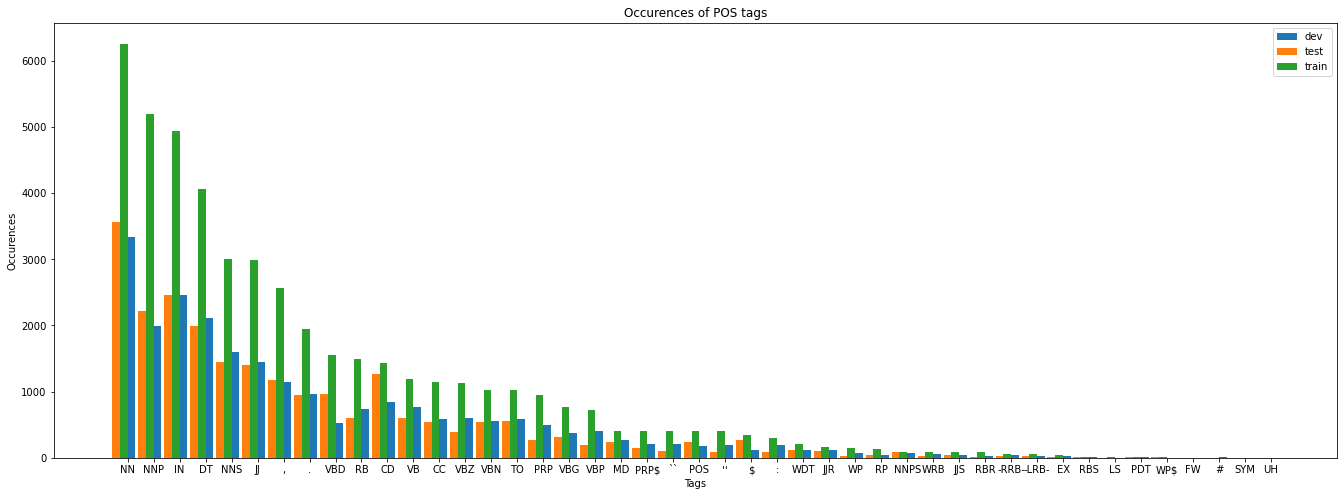

In [7]:
# plot bar chart of the occurences of each POS tag
fig, ax = plt.subplots(1, 1, figsize=(23, 8))
tags = list(train_tags_occ.keys())
ax.bar(tags, tags_occ[:, 1], width=0.3, align='edge', label='dev')
ax.bar(tags, tags_occ[:, 2], width=-0.6, align='edge', label='test')
ax.bar(tags, tags_occ[:, 0], width=-0.3, align='edge', label='train')
ax.set_xticks(tags)
ax.set_xlabel('Tags')
ax.set_ylabel('Occurences')
ax.set_title("Occurences of POS tags")
ax.legend()
plt.plot()

In [8]:
# analyze the difference between the presence of the POS tags in the train, dev and test sets
train_tags_not_dev = set(train_tags_occ.keys()) - set(dev_tags_occ.keys())
train_tags_not_test = set(train_tags_occ.keys()) - set(test_tags_occ.keys())
dev_tags_not_train = set(dev_tags_occ.keys()) - set(train_tags_occ.keys())
test_tags_not_train = set(test_tags_occ.keys()) - set(train_tags_occ.keys())

if(len(train_tags_not_dev) > 0):
    print("The following tags (from the train set) are not in the dev set:", train_tags_not_dev)
if(len(train_tags_not_test) > 0):
    print("The following tags (from the train set) are not in the test set:", train_tags_not_test)
if(len(dev_tags_not_train) > 0):
    print("The following tags (from the dev set) are not in the train set:", dev_tags_not_train)
if(len(test_tags_not_train) > 0):
    print("The following tags (from the test set) are not in the train set:", test_tags_not_train)

The following tags (from the train set) are not in the dev set: {'SYM'}
The following tags (from the train set) are not in the test set: {'LS', 'SYM', 'UH', 'FW'}


### 1.3 GloVe embeddings vectorization
The next step consists in downloading a pre-trained embedding model, namely GloVe. It is a techniques that tries to encoded global semantic properties based on the co-occurrence matrix.
Three different dimensional space versions are available: 50, 100, 200.

From the choosen embedding, a starting vocabulary is built.
Then this vocabulary is enriched with the embeddings computed for the OOV words.

In [9]:
# initialize the vectorizer for the input tokens to convert them to embedding vectors
# and build the vocabulary V1 from the glove embeddings
text_vectorizer = TextVectorizer(
    glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
    embedding_dim=100,
    embedding_folder=os.path.join(os.getcwd(), "glove"),
    max_size=dataset.max_size
)

# compute embeddings for terms (OOV1) in the training set that are out of vocabulary V1 and add them: V2=V1+OOV1
print("Parsing the training set...")
text_vectorizer.adapt(X_train)
# use the vocabulary V2 to convert the training set inputs into embedding vectors
X_train = text_vectorizer.transform(X_train)

# compute embeddings for terms (OOV2) in the validation set that are out of vocabulary V2 and add them: V3=V2+OOV2
print("\nParsing the validation set...")
text_vectorizer.adapt(X_dev)
# use the vocabulary V3 to convert the validation set inputs into embedding vectors
X_dev = text_vectorizer.transform(X_dev)

# compute embeddings for terms (OOV3) in the test set that are out of vocabulary V3 and add them: V4=V3+OOV3
print("\nParsing the test set...")
text_vectorizer.adapt(X_test)
# use the vocabulary V4 to convert the test set inputs into embedding vectors
X_test = text_vectorizer.transform(X_test)

Parsing the training set...
Generated embeddings for 358 OOV words.

Parsing the validation set...
Generated embeddings for 131 OOV words.

Parsing the test set...
Generated embeddings for 187 OOV words.


In [10]:
print(f"Input shape: {X_train.shape}")

Input shape: (1957, 249, 100)


### 1.4 One-hot encoding of the targets
Each POS tag in each set is converted using the one-hot representation

In [11]:
# initialize the vectorizer for the target tags to convert them into one-hot representation
target_vectorizer = TargetVectorizer(max_size=dataset.max_size)

# adapt the target vectorizer with only the training set: we do not consider possible targets that are not seen in training set but they are in the dev/test set
target_vectorizer.adapt(y_train)  

# convert the targets into one-hot representation for each splitting set
y_train = target_vectorizer.transform(y_train)
y_dev = target_vectorizer.transform(y_dev)
y_test = target_vectorizer.transform(y_test)

n_classes = y_train[0].shape[1]

In [12]:
print(f"Target shape: {y_train.shape}")
print(f"Number of classes for one-hot encoded targets: {n_classes}")

Target shape: (1957, 249, 45)
Number of classes for one-hot encoded targets: 45


## 2. Training

### 2.1 Models definition
We are now ready to define our neural network architectures! 
Four variants will be evaluated:
- Bidirectional LSMT + Dense layer
- Bidirectional GRU + Dense layer
- Two Bidirectional LSMT + Dense layer
- Bidirectional LSMT + Two Dense layer

In [13]:
tfa_f1 = tfa.metrics.F1Score(
    num_classes= n_classes,
    name = 'f1_score',
    )
punctuation_indices = [0, 1, 2, 3, 4, 5, 6,7, 16, 30, 43]

def f1_with_tfa(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, n_classes))
    punctuation = tf.gather(y_true, punctuation_indices, axis=-1)
    y_mask = tf.cast(tf.logical_not(tf.reduce_any(tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    tfa_f1.update_state(y_true, y_pred, sample_weight=y_mask)
    result = tfa_f1.result()
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in tfa_f1.variables])
    return K.sum(result)/(n_classes-len(punctuation_indices))

In [ ]:
def build_bilstm_model(hp):
    """
    Build th Bidirectional LSMT + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_bigru_model(hp):
    """
    Build th Bidirectional GRU + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.GRU(hp.Choice('units', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="gru_1"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_two_bilstm_model(hp):
    """
    Build the Two Bidirectional LSTM + Dense layer model
    """
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units1', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units2', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_2"))
    model.add(layers.Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_1"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

def build_bilstm_two_dense_model(hp):
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units1', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Dropout(hp.Choice('dropout1', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(hp.Choice('units2', [64, 128, 256]), activation="relu", name="dense_1", kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(hp.Choice('dropout2', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(n_classes, activation="softmax", name="dense_2"))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

### 2.2 Hyperparameter tuning
Let's do a tuning of the hyperparameters for each variant of the architecture

In [ ]:
epochs_tuning = 100
batch_size_tuning = 64

Model 1: Bidirectional LSMT + Dense layer variant tuning


In [ ]:
# tune the hyperparameters of the first model
tuner_bilstm = kt.Hyperband(build_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm")
tuner_bilstm.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 51 Complete [00h 00m 13s]
val_f1_with_tfa: 0.016184546053409576

Best val_f1_with_tfa So Far: 0.3293497860431671
Total elapsed time: 00h 11m 43s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 256.
The optimal rate for Dropout layer is 0.0.
The optimal learning rate for the optimizer is 0.01.


Model 2: Bidirectional GRU + Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the second model
tuner_bigru = kt.Hyperband(build_bigru_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bigru")
tuner_bigru.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the GRU layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bigru.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 47 Complete [00h 00m 14s]
val_f1_with_tfa: 0.4459829032421112

Best val_f1_with_tfa So Far: 0.4689154028892517
Total elapsed time: 00h 10m 11s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the GRU layer is 256.
The optimal rate for Dropout layer is 0.1.
The optimal learning rate for the optimizer is 0.01.


Model 3: Two Bidirectional LSMT + Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the third model
tuner_two_bilstm = kt.Hyperband(build_two_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_two_bilstm")
tuner_two_bilstm.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the first LSTM layer is {best_hps_two_bilstm.get('units1')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_two_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 161 Complete [00h 00m 29s]
val_f1_with_tfa: 0.024244248867034912

Best val_f1_with_tfa So Far: 0.49006524682044983
Total elapsed time: 01h 22m 18s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the first LSTM layer is 128.
The optimal number of units in the second LSTM layer is 256.
The optimal rate for Dropout layer is 0.4.
The optimal learning rate for the optimizer is 0.001.


Model 4: Bidirectional LSMT + two Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the fourth model
tuner_bilstm_two_dense = kt.Hyperband(build_bilstm_two_dense_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm_two_dense")
tuner_bilstm_two_dense.search(X_train, y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_dev, y_dev))
best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm_two_dense.get('units1')}.\n" 
      f"The optimal rate for the first Dropout layer is {best_hps_bilstm_two_dense.get('dropout1')}.\n" 
      f"The optimal number of units in first densely-connected layer is {best_hps_bilstm_two_dense.get('units2')}.\n" 
      f"The optimal rate for the second Dropout layer is {best_hps_bilstm_two_dense.get('dropout2')}.\n"
      f"The optimal learning rate for the optimizer is {best_hps_bilstm_two_dense.get('learning_rate')}.")

Trial 254 Complete [00h 02m 56s]
val_f1_with_tfa: 0.1206110268831253

Best val_f1_with_tfa So Far: 0.4763255715370178
Total elapsed time: 01h 52m 40s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 64.
The optimal rate for the first Dropout layer is 0.0.
The optimal number of units in first densely-connected layer is 256.
The optimal rate for the second Dropout layer is 0.2.
The optimal learning rate for the optimizer is 0.01.


### 2.3 Model training

In [14]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_f1_with_tfa', patience=10, mode="max", restore_best_weights=True)]

In [16]:
def create_model(layers_info, compile_info):
    """
    Create a Keras model given a list of layer information

    Parameters
    ----------
    layers_info : a list of dictionaries, one for each layer
    compile_info : dictionary containing compile information

    Returns
    -------
    model: the built keras sequential model
    """

    model = keras.Sequential()
    for info in layers_info:
        layer = info['layer_name'](**{key: value for key, value in info.items() if key != 'layer_name'})
        model.add(layer)

    # Compile
    model.compile(**compile_info)

    return model

Model 1: Bidirectional LSMT + Dense layer variant training

In [ ]:
# first model    
layers_info_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_bilstm.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bilstm.get('dropout'),
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bilstm.get('learning_rate')),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bilstm = create_model(layers_info_bilstm, compile_info_bilstm)
model_bilstm.summary()

# start training
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

NameError: ignored

Model 2: Bidirectional GRU + Dense layer variant training

In [ ]:
# second model    
layers_info_bigru = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.GRU(best_hps_bigru.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bigru_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bigru.get('dropout'),
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bigru = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bigru.get('learning_rate')),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bigru = create_model(layers_info_bigru, compile_info_bigru)
model_bigru.summary()

# start training
history_bigru = model_bigru.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev),  callbacks=callbacks_training)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bigru_1 (Bidirectional)     (None, 249, 512)          549888    
                                                                 
 dropout_1 (Dropout)         (None, 249, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 45)           23085     
                                                                 
Total params: 572,973
Trainable params: 572,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 10s 138ms/step - loss: 0.6718 - categorical_accuracy: 0.4791 - f1_with_tfa: 0.1918 - val_loss: 0.2034 - val_categorical_accurac

Model 3: Two Bidirectional LSMT + Dense layer variant training

In [ ]:
# third model    
layers_info_two_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units1'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bilstm_1",
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units2'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bilstm_2",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_two_bilstm.get('dropout'),
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_two_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_two_bilstm.get('learning_rate')),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_two_bilstm = create_model(layers_info_two_bilstm, compile_info_two_bilstm)
model_two_bilstm.summary()

# start training
history_two_bilstm = model_two_bilstm.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bilstm_1 (Bidirectional)    (None, 249, 256)          234496    
                                                                 
 bilstm_2 (Bidirectional)    (None, 249, 512)          1050624   
                                                                 
 dropout_1 (Dropout)         (None, 249, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 45)           23085     
                                                                 
Total params: 1,308,205
Trainable params: 1,308,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [=========================

Model 4: Bidirectional LSMT + two Dense layer variant training

In [ ]:
# fourth model    
layers_info_bilstm_two_dense = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_bilstm_two_dense.get('units1'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bilstm_two_dense.get('dropout1'),
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": best_hps_bilstm_two_dense.get('units2'),
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01),
        "name": "dense_1"
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bilstm_two_dense.get('dropout2'),
        "name": "dropout_2"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_2"
    }
]

compile_info_bilstm_two_dense = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bilstm_two_dense.get('learning_rate')),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bilstm_two_dense = create_model(layers_info_bilstm_two_dense, compile_info_bilstm_two_dense)
model_bilstm_two_dense.summary()

# start training
history_bilstm_two_dense = model_bilstm_two_dense.fit(X_train, y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_dev, y_dev), callbacks=callbacks_training)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (None, 249, 100)          0         
                                                                 
 bilstm_1 (Bidirectional)    (None, 249, 128)          84480     
                                                                 
 dropout_1 (Dropout)         (None, 249, 128)          0         
                                                                 
 dense_1 (Dense)             (None, 249, 256)          33024     
                                                                 
 dropout_2 (Dropout)         (None, 249, 256)          0         
                                                                 
 dense_2 (Dense)             (None, 249, 45)           11565     
                                                                 
Total params: 129,069
Trainable params: 129,069
Non-tr

#### 2.3.1 Store or load all the trained models

Store weights and history

In [ ]:
# store models weights
path_model_weights = os.path.join(os.getcwd(), 'models_f1', 'weights')
model_bilstm.save_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.save_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.save_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.save_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))

In [ ]:
# convert the history.history dict to a pandas DataFrame: 
path_model_weights = os.path.join(os.getcwd(), 'models_f1', 'history')
    
df_history_bilstm = pd.DataFrame(history_bilstm.history) 
with open(os.path.join(path_model_weights, "history_bilstm.csv"), mode="w") as file:
    df_history_bilstm.to_csv(file)

df_history_bigru = pd.DataFrame(history_bigru.history)
with open(os.path.join(path_model_weights, "history_bigru.csv"), mode="w") as file:
    df_history_bigru.to_csv(file)

df_history_two_bilstm = pd.DataFrame(history_two_bilstm.history)
with open(os.path.join(path_model_weights, "history_two_bilstm.csv"), mode="w") as file:
    df_history_two_bilstm.to_csv(file)

df_history_bilstm_two_dense = pd.DataFrame(history_bilstm_two_dense.history)
with open(os.path.join(path_model_weights, "history_bilstm_two_dense.csv"), mode="w") as file:
    df_history_bilstm_two_dense.to_csv(file)

Read structure and weights

In [15]:
path_model_structure = os.path.join(os.getcwd(), 'models_f1', 'structure')
with open(os.path.join(path_model_structure, 'model_bilstm.json'), 'r') as json_file:
    model_bilstm_json = json_file.read()    
    model_bilstm = model_from_json(model_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bigru.json'), 'r') as json_file:
    model_bigru_json = json_file.read()    
    model_bigru = model_from_json(model_bigru_json)

with open(os.path.join(path_model_structure, 'model_two_bilstm.json'), 'r') as json_file:
    model_two_bilstm_json = json_file.read()    
    model_two_bilstm = model_from_json(model_two_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bilstm_two_dense.json'), 'r') as json_file:
    model_bilstm_two_dense_json = json_file.read()    
    model_bilstm_two_dense = model_from_json(model_bilstm_two_dense_json)

In [16]:
# Restore the weights
path_model_weights = os.path.join(os.getcwd(), 'models_f1', 'weights')
model_bilstm.load_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.load_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.load_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.load_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))

In [41]:
# Restore history
cols = ['loss','categorical_accuracy','f1_with_tfa','val_loss','val_categorical_accuracy','val_f1_with_tfa']
path_model_history = os.path.join(os.getcwd(), 'models_f1', 'history')
history_bilstm = pd.read_csv(os.path.join(path_model_history, "history_bilstm.csv"), usecols=cols)
history_bigru = pd.read_csv(os.path.join(path_model_history, "history_bigru.csv"), usecols=cols)
history_two_bilstm = pd.read_csv(os.path.join(path_model_history, "history_two_bilstm.csv"), usecols=cols)
history_bilstm_two_dense = pd.read_csv(os.path.join(path_model_history, "history_bilstm_two_dense.csv"), usecols=cols)

### 2.4 History of the training
Plot metrics evolution for each epoch during the training

In [42]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

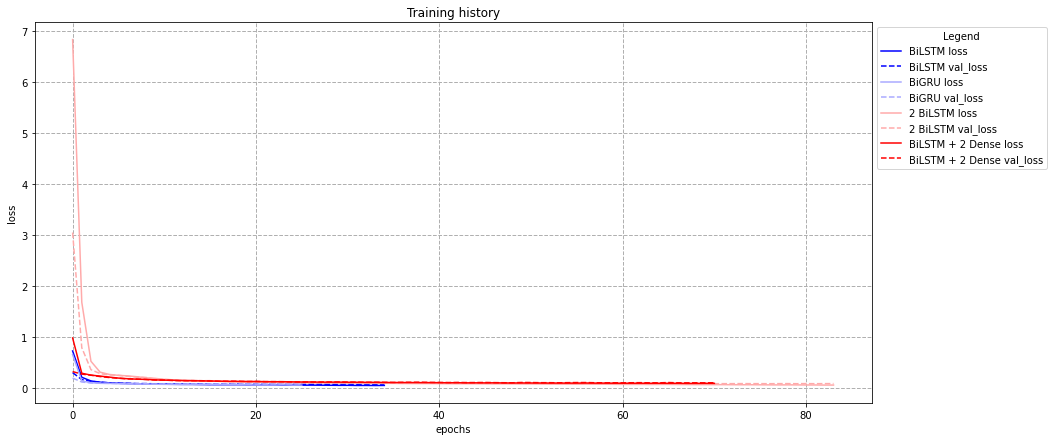

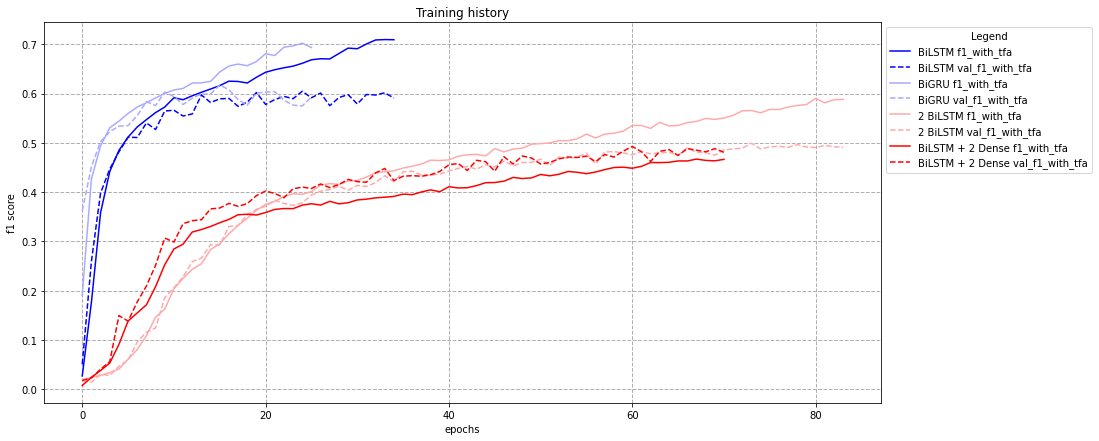

In [43]:
models_history = [history_bilstm, history_bigru, history_two_bilstm, history_bilstm_two_dense]
model_names = ["BiLSTM", "BiGRU", "2 BiLSTM", "BiLSTM + 2 Dense"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), figsize=(15,7),  cmap='bwr')
plot_history(models_history, keys=['f1_with_tfa', 'val_f1_with_tfa'], model_names=model_names, labels=("epochs", "f1 score"), figsize=(15,7),  cmap='bwr')

## 3. Evaluation

The two best models according to validation set are **BiLSTM** and **BiGRU**. Therefore the test set will be used with both of them.

In [19]:
def adapt_output_for_evaluation(y_true, y_pred):
  """
  given true outputs and predicted ones, this function returns
  both of them in 1D and as classes and not probability distributions
  """
  len_sentence = y_pred.shape[1]
  num_sentences = y_pred.shape[0]
  pred_val = np.empty((num_sentences, len_sentence))
  true_val = np.empty((num_sentences, len_sentence))
  # assign label with the highest probability
  for i in range(num_sentences):
      for j in range(len_sentence):
          pred_val[i,j] = np.argmax(y_pred[i,j,:])
          true_val[i,j] = np.argmax(y_true[i,j,:])
  # flatten the numpy array to have a 1D array
  true_val = true_val.flatten()
  pred_val = pred_val.flatten()
  return true_val, pred_val

The *classification report* is a summary of the metrics (precision, recall, f1_score) computed for each class and globally (micro, macro and weighted)

In [20]:
def show_classification_report(model, X_test, y_test, labels, names, sorted_by=None, ascending=True):
  """
  Show classification report using only classes in names
  """
  raw_y_true = np.array(y_test)
  raw_y_pred = model.predict(X_test)
  y_true, y_pred = adapt_output_for_evaluation(raw_y_true, raw_y_pred)
  dictionary =  classification_report(y_true, y_pred, labels=labels, target_names=names, output_dict=True, zero_division=0)
  # global performance
  keys = ['weighted avg', 'micro avg', 'macro avg']
  global_dict = {key: dictionary[key] for key in keys}
  for key in keys:
    del dictionary[key]

  df = pd.DataFrame.from_dict(dictionary).transpose().round(2)
  if sorted_by:
    df.sort_values(by=sorted_by, ascending=ascending, inplace=True)
  print(df)

  print("\n\n")

  df_glob = pd.DataFrame.from_dict(global_dict).transpose().round(2)
  print(df_glob)

The *confusion matrix* can be very useful to understand main errors committed by the model

In [21]:
def evaluate_model(model, X_test, y_test, labels):
    """
    given a trained model and a test set returns the f-score and the confusion matrix
    taking into account only classes in labels
    """
    raw_y_true = np.array(y_test)
    raw_y_pred = model.predict(X_test)
    y_true, y_pred = adapt_output_for_evaluation(raw_y_true, raw_y_pred)
    # show confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(conf_matrix)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    # f1 score
    print("F score:\n-------------------------------\n")
    print(sklearn.metrics.f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0))

It is not interesting evaluating *punctuation classes*, therefore they are not taken into account in the final evaluation

In [22]:
punctuation_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 16, 30, 43]
classes = target_vectorizer.get_classes()
valid_labels = list(set(range(len(classes))) - set(punctuation_indexes))
meaningful_classes = classes[valid_labels]

BiLSTM and BiGRU model have been created using the best hyperparameter found by the tuner

### BiLSTM Model

In [25]:
layers_info_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(256, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.0,
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": 45,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.01),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bilstm = create_model(layers_info_bilstm, compile_info_bilstm)

F score:
-------------------------------

0.006121455334711955


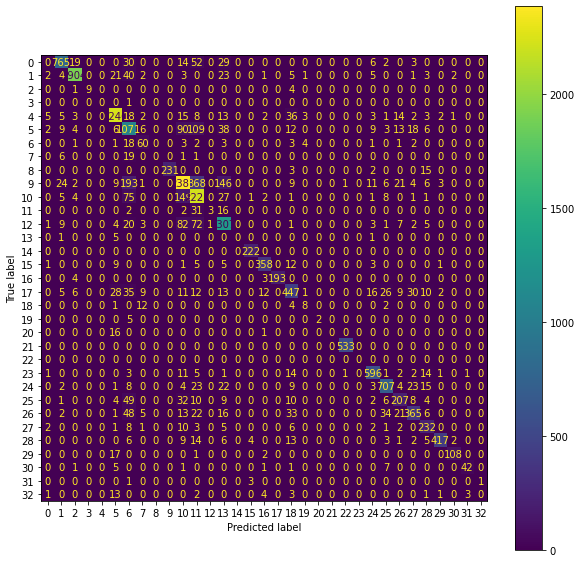

In [26]:
# confusion matrix and global f1 score
model_bilstm.load_weights("weights_bilstm.h5")
evaluate_model(model_bilstm, X_test, y_test, valid_labels)

In [27]:
# classification report using only meaningful classes
show_classification_report(model_bilstm, X_test, y_test, valid_labels, meaningful_classes, sorted_by=['f1-score'], ascending=False)

      precision  recall  f1-score  support
NNP        0.05    0.06      0.06   2496.0
VBN        0.07    0.04      0.05    566.0
JJR        0.01    0.18      0.02     99.0
NNPS       0.01    0.57      0.02     54.0
PRP$       0.01    0.02      0.01    200.0
RBR        0.01    0.15      0.01     27.0
VBG        0.01    0.02      0.01    342.0
VBZ        0.02    0.01      0.01    482.0
VBP        0.00    0.00      0.00    273.0
WDT        0.00    0.00      0.00    128.0
WP         0.00    0.00      0.00     62.0
WP$        0.00    0.00      0.00      5.0
VBD        0.00    0.00      0.00    821.0
VB         0.00    0.00      0.00    654.0
UH         0.00    0.00      0.00      0.0
TO         0.00    0.00      0.00    533.0
RP         0.00    0.00      0.00     46.0
RBS        0.00    0.00      0.00      7.0
CD         0.00    0.00      0.00    931.0
RB         0.00    0.00      0.00    677.0
DT         0.00    0.00      0.00   2017.0
PRP        0.00    0.00      0.00    396.0
POS        

### BiGRU Model

In [ ]:
layers_info_bigru = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.GRU(256, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
        "name": "bigru_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.1,
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bigru = {
    'optimizer': keras.optimizers.Adam(0.01),
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bigru = create_model(layers_info_bigru, compile_info_bigru)

In [ ]:
# confusion matrix and global f1 score
model_bigru.load_weights("weights_bigru.h5")
evaluate_model(model_bigru, X_test, y_test, valid_labels)

In [ ]:
# classification report using only meaningful classes
show_classification_report(model_bilstm, X_test, y_test, valid_labels, meaningful_classes, sorted_by=['f1-score'], ascending=False)

## Results and examples

In [ ]:
i_test = 2  # change this to see the prediction for a different sentence

print("Original POS tagging: ",target_vectorizer.inverse_transform([y_test[i_test]])[0])

raw_y_pred = model_bilstm.predict(np.array([X_test[i_test]]))
# shape of the output is doc x len_sen x classes
# argmax for label predictions

print("Predicted POS tagging: ",target_vectorizer.inverse_transform_probabilities(raw_y_pred)[0])

Original POS tagging:  ['IN' 'DT' 'CD' 'IN' 'CD' ',' 'DT' 'CD' 'CD' 'NNS' 'VBD' 'DT' 'JJ' 'NN'
 'NN' '-LRB-' 'NNP' '-RRB-' 'TO' 'VB' 'NNS' 'CC' 'NN' 'NN' '.']
Predicted POS tagging:  ['IN' 'DT' 'NNP' 'NNP' 'NNP' ',' 'RB' 'CD' 'NNS' 'NNS' 'VBD' 'DT' 'JJ'
 'VBG' 'NNP' '-LRB-' 'NNP' '-RRB-' 'TO' 'VB' 'NNS' 'CC' 'NNP' 'NN' '.']
